# Gaussian mixture model background subtraction for _in situ_ XRD

Using cycad for easy file import but can also use standard dataframe

In [36]:
from cycad import cycad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from ipywidgets import interact, interactive, fixed, interact_manual

Here we instantiate a cycad object, and load data to the cycad.df dataframe.

Todo: work out why file loading speed is highly inconsistent (should be very fast in ideal case)

In [38]:
# Instantiate cycad object
frames = cycad()

# Load data folder and read data 
data_folder = 's02_r05'
frames.read_folder(data_folder, 'xye')

# # Restrict data range for XRD data
# frames.df = frames.df[200:1600].reset_index(drop=True)


100%|██████████| 2224/2224 [00:02<00:00, 847.66it/s]


Plot data to make sure it's what we expect.
so2_r05 is metal additive manufacturing XRD data
- Phase of interest is aluminium which undergoes a small thermal expansion
- Beryllium and substrate peaks in background

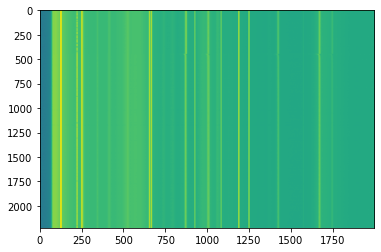

In [39]:
plt.imshow(frames.df.T, aspect='auto', norm=LogNorm())
plt.show()

<AxesSubplot:>

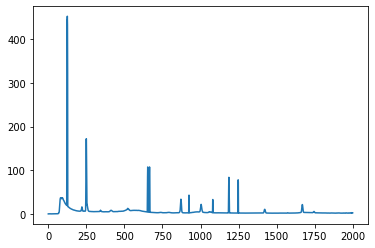

In [42]:
# Plot a single frame to check diffraction looks normal
frames.df.T.iloc[10].plot()

#### Procedure
1. Get each row of data (one x-axis bin)
2. Fit a 2-component GMM to each pixel
3. Subtract the first GMM component from the raw data

First orient the dataframe and plot a row as a sanity check

<AxesSubplot:>

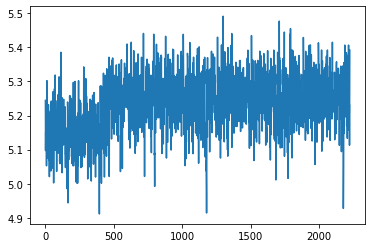

In [47]:
# Re-orient and drop X column
frames_gmm = frames.df.T[1:]

# drop dataframe index
frames_gmm = frames_gmm.reset_index(drop=True)

# Plot a row - expect to see mostly flat curve with changes if the position overlaps scattering features
frames_gmm[400].plot()


Define a function to fit a GMM with n components to each column of a dataframe, df

In [48]:
from sklearn.mixture import GaussianMixture
import pandas as pd

def gmm_background(n_components, df):
    gmm_means = df.apply(lambda x: GaussianMixture(n_components=n_components).fit(x.values.reshape(-1, 1)))
    gmm_means = gmm_means.apply(lambda x: x.means_.flatten())
    output = pd.DataFrame()
    for i in range(n_components):
        output[i] = gmm_means.apply(lambda x: x[i])
    return output

Run the function on our dataframe

In [125]:
gmm_means = gmm_background(2, frames_gmm)
gmm_means

,0,1
0,0.006760,0.522176
1,0.000000,0.250495
2,0.263350,0.075895
3,0.093900,0.259233
4,0.090585,0.216009
...,...,...
1995,2.184280,1.801183
1996,1.712577,2.142982
1997,1.569455,2.073418
1998,2.019838,1.401369


Plot the GMM components

Certain regions correspond to shifting peaks. In this data, the GMM background contains some peak intensity because these peaks overlap throughout the whole dataset.

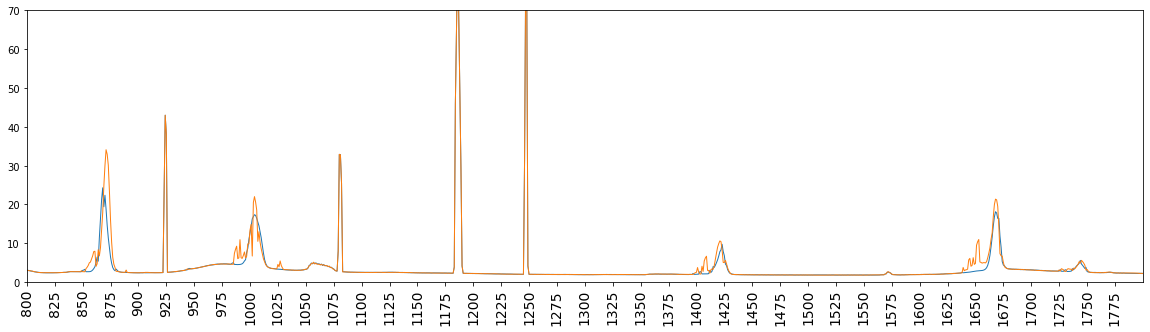

In [180]:
figure = plt.figure(figsize=(20, 5))
gmm_means[0][:].plot(linewidth=1)
gmm_means[1][:].plot(linewidth=1)
plt.xlim(800, 1800)
plt.ylim(0, 70)
# minor ticks labels
plt.xticks(range(800, 1800, 25), fontsize=14, rotation=90)
plt.show()

In [188]:
# Regions for peaks to be replaced with background
regions = [
    (850, 900),
    (980, 1025),
    (1400, 1440),
    (1650, 1680),
]

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(polynomial, prefix='poly_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 60
    # variables        = 6
    chi-square         = 34.4453005
    reduced chi-square = 0.63787594
    Akaike info crit   = -21.2983193
    Bayesian info crit = -8.73225197
[[Variables]]
    poly_c0:      -483.830990 +/- 376.050894 (77.72%) (init = 0)
    poly_c1:       1.12477807 +/- 0.86547542 (76.95%) (init = 0)
    poly_c2:      -6.4972e-04 +/- 4.9773e-04 (76.61%) (init = 0)
    g1_amplitude:  154.175515 +/- 4.90241290 (3.18%) (init = 25)
    g1_center:     868.928930 +/- 0.07492610 (0.01%) (init = 870)
    g1_sigma:      3.07814462 +/- 0.08795292 (2.86%) (init = 10)
    g1_fwhm:       7.24847651 +/- 0.20711330 (2.86%) == '2.3548200*g1_sigma'
    g1_height:     19.9818859 +/- 0.45367605 (2.27%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
[[Correlations]] (unreported correlations are < 0.50

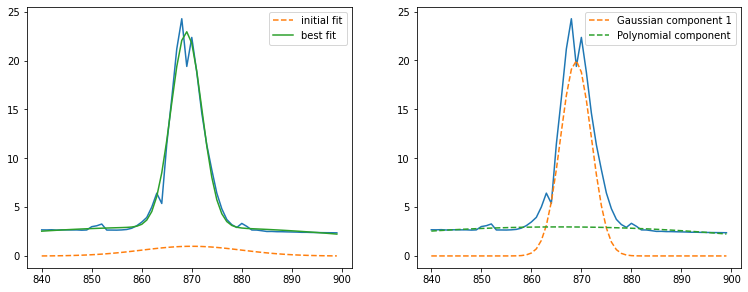

In [148]:
import lmfit
import numpy as np

from lmfit.models import GaussianModel, LinearModel, PolynomialModel

x = gmm_means[0][840:900].index
y = gmm_means[0][840:900]

lin_mod = LinearModel(prefix='lin_')
pars = lin_mod.guess(y, x=x)

poly_mod = PolynomialModel(2, prefix='poly_')
pars = poly_mod.guess(y, x=x, c0=0, c1=0, c2=0)

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params())

pars['g1_center'].set(value=870, min=860, max=880)
pars['g1_sigma'].set(value=10, min=3)
pars['g1_amplitude'].set(value=25, min=10)

mod = gauss1 + poly_mod

init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y)
axes[0].plot(x, init, '--', label='initial fit')
axes[0].plot(x, out.best_fit, '-', label='best fit')
axes[0].legend()

comps = out.eval_components(x=x)
axes[1].plot(x, y)
axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
# axes[1].plot(x, comps['lin_'], '--', label='Linear component')
axes[1].plot(x, comps['poly_'], '--', label='Polynomial component')
axes[1].legend()

plt.show()


<AxesSubplot:>

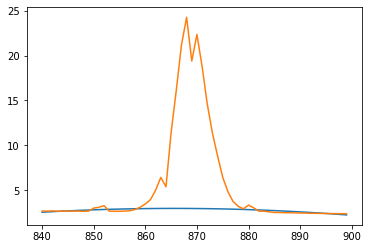

In [161]:
gmm_mean_peakfit = gmm_means[0].copy()
gmm_mean_peakfit[840:900] =  comps['poly_']
gmm_mean_peakfit[840:900].plot()
gmm_means[0][840:900].plot()

Test a function for fitting user-defined peaks in ranges [(a,b), (c,d), etc.] using lmfit with Gaussian plus a linear or polynomial background

In [169]:
import lmfit
import numpy as np

from lmfit.models import GaussianModel, LinearModel

def peak2bkg(start, end, data, poly_n=2):
    x = data[start:end].index
    y = data[start:end]

    # lin_mod = LinearModel(prefix='lin_')
    # pars = lin_mod.guess(y, x=x)

    poly_mod = PolynomialModel(poly_n, prefix='poly_')
    pars = poly_mod.guess(y, x=x, c0=0, c1=0, c2=0)

    gauss1 = GaussianModel(prefix='g1_')
    pars.update(gauss1.make_params())

    pars['g1_center'].set(value=(end+start)//2, min=start, max=end)
    pars['g1_sigma'].set(value=(end-start)//4, min=1)
    pars['g1_amplitude'].set(value=y.max(), min=1)

    mod = gauss1 + poly_mod

    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)

    # print(out.fit_report(min_correl=0.5))

    # fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    # axes[0].plot(x, y)
    # axes[0].plot(x, init, '--', label='initial fit')
    # axes[0].plot(x, out.best_fit, '-', label='best fit')
    # axes[0].legend()

    comps = out.eval_components(x=x)
    # axes[1].plot(x, y)
    # axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
    # axes[1].plot(x, comps['poly_'], '--', label='Polynomial component')
    # axes[1].legend()

    # plt.show()

    return comps['poly_']


Visually check if it's viable to replace the peaks in the real GMM background with the linear/polynomial background

<AxesSubplot:>

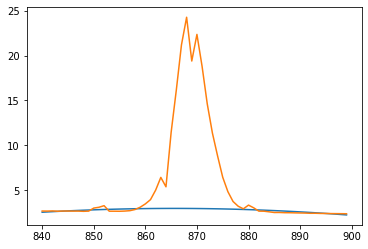

In [171]:
gmm_mean_peakfit = gmm_means[0].copy()
gmm_mean_peakfit[840:900] =  peak2bkg(840, 900, gmm_means[0])
gmm_mean_peakfit[840:900].plot()
gmm_means[0][840:900].plot()


(0.0, 100.0)

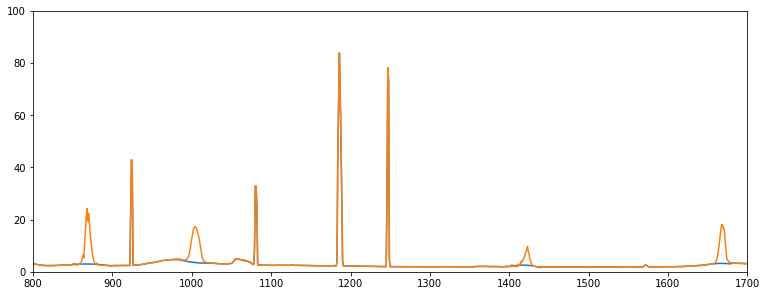

In [189]:
def peak_subtract(data, regions):
    data = data.copy()
    for start, end in regions:
        data[start:end] = peak2bkg(start, end, data)
    return data

gmm_mean_peakfit = peak_subtract(gmm_means[0], regions)

figure = plt.figure(figsize=(12.8, 4.8))
plt.plot(gmm_mean_peakfit)
plt.plot(gmm_means[0])
plt.xlim(800, 1700)
plt.ylim(0, 100)

Subtract GMM component from raw data

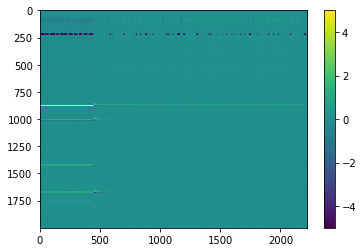

In [190]:
# Subtract background
frames_gmm_sub = frames_gmm - gmm_means[0]

# Plot corrected data
plt.imshow(frames_gmm_sub.T, aspect='auto', vmin=-5, vmax=5)
plt.colorbar()

Comparison - subtact peak-corrected GMM component from raw data

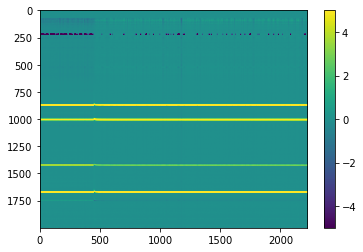

In [191]:
# Subtract background
frames_gmm_sub_peakfit = frames_gmm - gmm_mean_peakfit

# Plot corrected data
plt.imshow(frames_gmm_sub_peakfit.T, aspect='auto', vmin=-5, vmax=5)
plt.colorbar()

Show an interactive plot with the raw and subtracted data

In [206]:
@interact
def plot_gmm(frame = (0, 1999)):
    frames_gmm.iloc[frame].plot()
    frames_gmm_sub_peakfit.T[frame].plot()
    (frames_gmm_sub.T[frame] - 5).plot()
    plt.legend(['Original', 'GMM + Peak Fit', 'GMM uncorrected'])

    plt.xlim(800,1800)
    plt.ylim(-10, 40)

interactive(children=(IntSlider(value=999, description='frame', max=1999), Output()), _dom_classes=('widget-in…

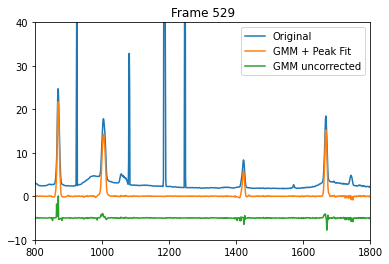

In [207]:
# make a plot animation
import matplotlib.animation as animation

fig, ax = plt.subplots()

def animate(frame):
    ax.clear()
    frames_gmm.iloc[frame].plot()
    frames_gmm_sub_peakfit.T[frame].plot()
    (frames_gmm_sub.T[frame] - 5).plot()
    ax.set_xlim(800,1800)
    ax.set_ylim(-10, 40)
    ax.set_title(f'Frame {frame}')


    ax.legend(['Original', 'GMM + Peak Fit', 'GMM uncorrected'])


# ani = animation.FuncAnimation(fig, animate, frames=2000, interval=1)
# animate from frame 200 to 500
ani = animation.FuncAnimation(fig, animate, frames=range(390, 530), interval=1)

ani.save('gmm_subtracted.mp4', writer='ffmpeg', fps=15)

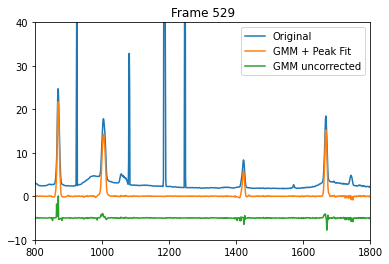

In [ ]:
# make a plot animation
import matplotlib.animation as animation

fig, ax = plt.subplots()

def animate(frame):
    ax.clear()
    frames_gmm.iloc[frame].plot()
    frames_gmm_sub_peakfit.T[frame].plot()
    (frames_gmm_sub.T[frame] - 5).plot()
    ax.set_xlim(800,1800)
    ax.set_ylim(-10, 40)
    ax.set_title(f'Frame {frame}')


    ax.legend(['Original', 'GMM + Peak Fit', 'GMM uncorrected'])


# ani = animation.FuncAnimation(fig, animate, frames=2000, interval=1)
# animate from frame 200 to 500
ani = animation.FuncAnimation(fig, animate, frames=range(390, 530), interval=1)

ani.save('gmm_subtracted.mp4', writer='ffmpeg', fps=15)